In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [20]:
import os

dataset_path = "/kaggle/input/chest-xray-pneumonia"  # correct spelling

print("Path exists:", os.path.exists(dataset_path))
if os.path.exists(dataset_path):
    print("Folders inside:", os.listdir(dataset_path))


Path exists: True
Folders inside: ['chest_xray']


In [21]:
def explore_dataset(path):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, "").count(os.sep)
        indent = " " * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = " " * 4 * (level + 1)
        for f in files[:5]:  # only show 5 files per folder
            print(f"{subindent}{f}")
        if len(files) > 5:
            print(f"{subindent}... {len(files)-5} more files")

if os.path.exists(dataset_path):
    explore_dataset(dataset_path)


chest-xray-pneumonia/
    chest_xray/
        chest_xray/
            .DS_Store
            val/
                .DS_Store
                PNEUMONIA/
                    person1947_bacteria_4876.jpeg
                    person1946_bacteria_4875.jpeg
                    person1952_bacteria_4883.jpeg
                    person1954_bacteria_4886.jpeg
                    person1951_bacteria_4882.jpeg
                    ... 4 more files
                NORMAL/
                    NORMAL2-IM-1431-0001.jpeg
                    NORMAL2-IM-1440-0001.jpeg
                    NORMAL2-IM-1442-0001.jpeg
                    NORMAL2-IM-1427-0001.jpeg
                    NORMAL2-IM-1430-0001.jpeg
                    ... 4 more files
            test/
                .DS_Store
                PNEUMONIA/
                    person1676_virus_2892.jpeg
                    person1650_virus_2852.jpeg
                    person22_virus_55.jpeg
                    person122_bacteria_582.jpeg
                

In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from collections import Counter

# ✅ Set dataset root (adjust if needed)
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# ✅ Image transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),  # resize for CNNs (like ResNet, Inception, etc.)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# ✅ Load train/val/test using ImageFolder
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# ✅ Wrap into DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# ✅ Function to count images per class
def class_distribution(dataset):
    counts = Counter([label for _, label in dataset.samples])
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    return {idx_to_class[k]: v for k,v in counts.items()}

# ✅ Print stats
print("Train size:", len(train_dataset), class_distribution(train_dataset))
print("Val size:", len(val_dataset), class_distribution(val_dataset))
print("Test size:", len(test_dataset), class_distribution(test_dataset))


Train size: 5216 {'NORMAL': 1341, 'PNEUMONIA': 3875}
Val size: 16 {'NORMAL': 8, 'PNEUMONIA': 8}
Test size: 624 {'NORMAL': 234, 'PNEUMONIA': 390}


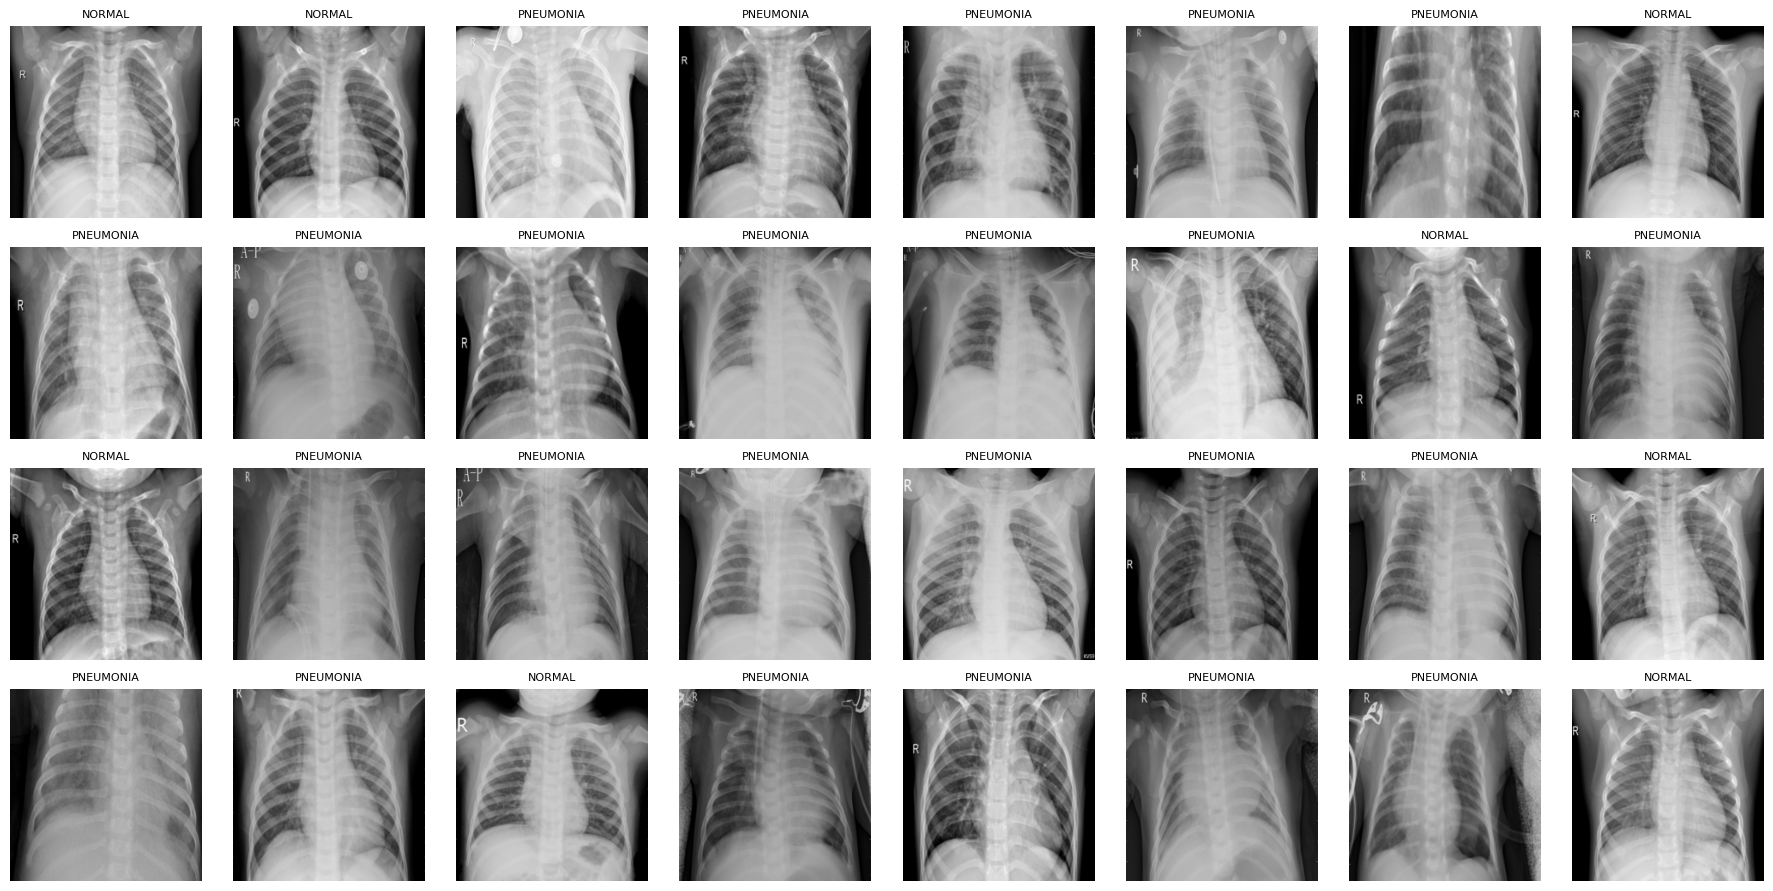

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Get class names
class_names = train_dataset.classes  # ['NORMAL', 'PNEUMONIA']

# ✅ Function to show a batch of images
def imshow_batch(images, labels):
    images = images.numpy().transpose((0, 2, 3, 1))  # convert from Tensor (C,H,W) to (H,W,C)

    # unnormalize (reverse normalization)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)

    fig, axes = plt.subplots(4, 8, figsize=(18, 9))  # show 32 images (batch_size=32)
    axes = axes.flatten()
    for img, ax, label in zip(images, axes, labels):
        ax.imshow(img)
        ax.set_title(class_names[label], fontsize=8)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# ✅ Get one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow_batch(images, labels)


In [24]:
# Cell 1: imports and basic config
import os
import random
import math
from glob import glob
from collections import Counter
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ---- Config ----
DATA_ROOT = "/kaggle/input/chest-xray-pneumonia/chest_xray"  # change if needed
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS = 25
LR = 1e-4
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)


Device: cuda


In [25]:
# Cell 2: Create pandas DataFrames for train/val/test (x_col=path, y_col=label)
def build_df(root_dir):
    data = []
    for class_name in sorted(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fp in glob(os.path.join(class_dir, "*")):
            # skip hidden files like .DS_Store
            if os.path.isfile(fp) and not os.path.basename(fp).startswith('.'):
                data.append({"path": fp, "label": class_name})
    return pd.DataFrame(data)

train_df = build_df(os.path.join(DATA_ROOT, "train"))
val_df   = build_df(os.path.join(DATA_ROOT, "val"))
test_df  = build_df(os.path.join(DATA_ROOT, "test"))

print("Samples counts:")
print(" Train:", len(train_df), " Val:", len(val_df), " Test:", len(test_df))
print("\nTrain class distribution:\n", train_df['label'].value_counts())
print("\nVal class distribution:\n", val_df['label'].value_counts())
print("\nTest class distribution:\n", test_df['label'].value_counts())


Samples counts:
 Train: 5216  Val: 16  Test: 624

Train class distribution:
 label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

Val class distribution:
 label
NORMAL       8
PNEUMONIA    8
Name: count, dtype: int64

Test class distribution:
 label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64


In [26]:
# Cell 3: Dataset and transforms
# Equivalent of ImageDataGenerator(rescale=1./255, horizontal_flip=True, brightness_range, rotation_range)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=(1.0, 1.3)),  # brightness_range
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),  # produces values in [0,1]
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class ChestXrayDataset(Dataset):
    def __init__(self, df, transform=None, class_map=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        # create mapping label -> index (sparse class_mode behavior)
        if class_map is None:
            labels = sorted(self.df['label'].unique())
            class_map = {c:i for i,c in enumerate(labels)}
        self.class_map = class_map
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.class_map[row['label']]
        return img, label

# Create consistent class_map across datasets
labels_sorted = sorted(train_df['label'].unique())
class_map = {c:i for i,c in enumerate(labels_sorted)}
inv_class_map = {v:k for k,v in class_map.items()}
print("Class map:", class_map)

train_ds = ChestXrayDataset(train_df, transform=train_transforms, class_map=class_map)
val_ds   = ChestXrayDataset(val_df, transform=val_test_transforms, class_map=class_map)
test_ds  = ChestXrayDataset(test_df, transform=val_test_transforms, class_map=class_map)


Class map: {'NORMAL': 0, 'PNEUMONIA': 1}


In [27]:
# Cell 4: DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Batches per split -> train:", len(train_loader), " val:", len(val_loader), " test:", len(test_loader))

# Optional: show one batch shapes
batch_imgs, batch_labels = next(iter(train_loader))
print("Batch images shape:", batch_imgs.shape, " Batch labels shape:", batch_labels.shape)


Batches per split -> train: 163  val: 1  test: 20


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch images shape: torch.Size([32, 3, 224, 224])  Batch labels shape: torch.Size([32])


In [28]:
# Cell 5: GoogLeNet (Inception v1) implementation
# This is a compact but faithful implementation of GoogleNet / Inception v1 (aux classifiers included).
class InceptionA(nn.Module):
    def __init__(self, in_ch, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()
        self.branch1 = nn.Sequential(nn.Conv2d(in_ch, ch1x1, 1), nn.ReLU(inplace=True))
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_ch, ch3x3red, 1), nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_ch, ch5x5red, 1), nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5, ch5x5, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_ch, pool_proj, 1), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1,b2,b3,b4], dim=1)

class InceptionB(nn.Module):
    # a reduction + inception, for when spatial size reduced by stride 2 conv/pool
    def __init__(self, in_ch, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()
        self.branch1 = nn.Sequential(nn.Conv2d(in_ch, ch3x3, 3, stride=2, padding=1), nn.ReLU(inplace=True))
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_ch, ch5x5red, 1), nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5, ch5x5, 3, stride=2, padding=1), nn.ReLU(inplace=True)
        )
        self.branch3 = nn.MaxPool2d(3, stride=2, padding=1)
    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        return torch.cat([b1,b2,b3], dim=1)

class AuxClassifier(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Conv2d(in_ch, 128, 1), nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128*4*4, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5),   # 🔹 changed from 0.7 → 0.5
            nn.Linear(1024, num_classes)
        )
    def forward(self, x):
        return self.net(x)


class GoogLeNetCustom(nn.Module):
    def __init__(self, num_classes=2, aux_logits=True):
        super().__init__()
        self.aux_logits = aux_logits

        # Initial layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,7,stride=2,padding=3), nn.ReLU(inplace=True),
            nn.MaxPool2d(3,stride=2,padding=1),
            nn.LocalResponseNorm(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,64,1), nn.ReLU(inplace=True),
            nn.Conv2d(64,192,3,padding=1), nn.ReLU(inplace=True),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(3,stride=2,padding=1)
        )

        # Inception blocks
        self.in3a = InceptionA(192, 64, 96, 128, 16, 32, 32)
        self.in3b = InceptionA(256, 128,128,192,32,96,64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.in4a = InceptionA(480, 192, 96, 208, 16, 48, 64)
        self.in4b = InceptionA(512, 160,112,224,24,64,64)
        self.in4c = InceptionA(512, 128,128,256,24,64,64)
        self.in4d = InceptionA(512,112,144,288,32,64,64)
        self.in4e = InceptionA(528,256,160,320,32,128,128)
        self.in5a = InceptionA(832,256,160,320,32,128,128)
        self.in5b = InceptionA(832,384,192,384,48,128,128)

        # Aux classifiers
        if aux_logits:
            self.aux1 = AuxClassifier(512, num_classes)
            self.aux2 = AuxClassifier(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

        # Final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.5)   # 🔹 changed from 0.4 → 0.5
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.in3a(x)
        x = self.in3b(x)
        x = self.maxpool(x)
        x = self.in4a(x)

        aux1 = None
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.in4b(x)
        x = self.in4c(x)
        x = self.in4d(x)

        aux2 = None
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.in4e(x)
        x = self.maxpool(x)
        x = self.in5a(x)
        x = self.in5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)   # 🔹 0.5 dropout applied before FC
        x = self.fc(x)

        return (x, aux1, aux2) if (self.aux_logits and self.training) else (x, None, None)


In [29]:
# Cell 6: instantiate model, criterion, optimizer
num_classes = len(class_map)
model = GoogLeNetCustom(num_classes=num_classes, aux_logits=True).to(DEVICE)

# ✅ Compute class weights from train set distribution
counts = train_df['label'].value_counts().sort_index()  # counts per class by name
counts_by_index = np.array([counts.get(inv_class_map[i], 0) for i in range(num_classes)])

# Inverse frequency: total / class_count
class_weights = torch.tensor(
    counts_by_index.sum() / (counts_by_index + 1e-8),
    dtype=torch.float
).to(DEVICE)

print("Train class counts:", counts_by_index, " -> Weights:", class_weights.cpu().numpy())

# ✅ Weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer + Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


Train class counts: [1341 3875]  -> Weights: [3.8896346 1.3460646]


In [30]:
# Cell 7: training loop
def accuracy_from_logits(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

best_val_loss = float('inf')
save_path = "googlenet_best.pth"

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - train")
    for imgs, labels in pbar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        outputs, aux1, aux2 = model(imgs)
        loss = criterion(outputs, labels)
        # aux losses (weighted as original paper: 0.3)
        if aux1 is not None and aux2 is not None:
            loss_aux1 = criterion(aux1, labels)
            loss_aux2 = criterion(aux2, labels)
            loss = loss + 0.3 * (loss_aux1 + loss_aux2)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_acc += accuracy_from_logits(outputs, labels) * imgs.size(0)
        n += imgs.size(0)
        pbar.set_postfix(loss=running_loss / n, acc=running_acc / n)

    train_loss = running_loss / n
    train_acc = running_acc / n

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    vn = 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - val"):
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            outputs, _, _ = model(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            val_running_acc += accuracy_from_logits(outputs, labels) * imgs.size(0)
            vn += imgs.size(0)

    val_loss = val_running_loss / max(1, vn)
    val_acc = val_running_acc / max(1, vn)
    scheduler.step(val_loss)

    print(f"Epoch {epoch} -> train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}")

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'class_map': class_map
        }, save_path)
        print("Saved best model to", save_path)


Epoch 1/25 - train:   0%|          | 0/163 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 1 -> train_loss: 1.0057 train_acc: 0.7418 | val_loss: 1.2689 val_acc: 0.6875
Saved best model to googlenet_best.pth


Epoch 2/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 2 -> train_loss: 0.5807 train_acc: 0.8236 | val_loss: 1.5035 val_acc: 0.6250


Epoch 3/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 3 -> train_loss: 0.4853 train_acc: 0.8623 | val_loss: 1.3916 val_acc: 0.6250


Epoch 4/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 4 -> train_loss: 0.4206 train_acc: 0.8823 | val_loss: 2.2929 val_acc: 0.5000


Epoch 5/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 5 -> train_loss: 0.3928 train_acc: 0.8947 | val_loss: 1.1586 val_acc: 0.5000
Saved best model to googlenet_best.pth


Epoch 6/25 - val: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Epoch 6 -> train_loss: 0.3880 train_acc: 0.8923 | val_loss: 1.7846 val_acc: 0.5000


Epoch 7/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 7 -> train_loss: 0.3578 train_acc: 0.8992 | val_loss: 0.6679 val_acc: 0.7500
Saved best model to googlenet_best.pth


Epoch 8/25 - val: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Epoch 8 -> train_loss: 0.3325 train_acc: 0.9080 | val_loss: 1.8234 val_acc: 0.5625


Epoch 9/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 9 -> train_loss: 0.2949 train_acc: 0.9206 | val_loss: 0.6767 val_acc: 0.6250


Epoch 10/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 10 -> train_loss: 0.2671 train_acc: 0.9275 | val_loss: 1.0467 val_acc: 0.6875


Epoch 11/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 11 -> train_loss: 0.2739 train_acc: 0.9270 | val_loss: 1.9471 val_acc: 0.6250


Epoch 12/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 12 -> train_loss: 0.2082 train_acc: 0.9488 | val_loss: 1.0020 val_acc: 0.7500


Epoch 13/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 13 -> train_loss: 0.2007 train_acc: 0.9507 | val_loss: 1.1421 val_acc: 0.6875


Epoch 14/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 14 -> train_loss: 0.1846 train_acc: 0.9542 | val_loss: 0.7131 val_acc: 0.6875


Epoch 15/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 15 -> train_loss: 0.1868 train_acc: 0.9559 | val_loss: 1.1529 val_acc: 0.6875


Epoch 16/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 16 -> train_loss: 0.1791 train_acc: 0.9571 | val_loss: 1.0528 val_acc: 0.6875


Epoch 17/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 17 -> train_loss: 0.1683 train_acc: 0.9599 | val_loss: 1.5374 val_acc: 0.6875


Epoch 18/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 18 -> train_loss: 0.1586 train_acc: 0.9609 | val_loss: 0.9243 val_acc: 0.6875


Epoch 19/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 19 -> train_loss: 0.1687 train_acc: 0.9601 | val_loss: 0.9693 val_acc: 0.7500


Epoch 20/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 20 -> train_loss: 0.1496 train_acc: 0.9630 | val_loss: 1.3377 val_acc: 0.6875


Epoch 21/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 21 -> train_loss: 0.1591 train_acc: 0.9622 | val_loss: 1.3172 val_acc: 0.6875


Epoch 22/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 22 -> train_loss: 0.1460 train_acc: 0.9636 | val_loss: 1.2179 val_acc: 0.6875


Epoch 23/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 23 -> train_loss: 0.1469 train_acc: 0.9649 | val_loss: 1.0415 val_acc: 0.6875


Epoch 24/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 24 -> train_loss: 0.1411 train_acc: 0.9676 | val_loss: 1.2977 val_acc: 0.6875


Epoch 25/25 - val: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

Epoch 25 -> train_loss: 0.1432 train_acc: 0.9661 | val_loss: 0.9585 val_acc: 0.7500


In [31]:
# Cell 8: load best model and evaluate on test set
ckpt = torch.load("googlenet_best.pth", map_location=DEVICE)
model.load_state_dict(ckpt['model_state'])
model.eval()

total = 0
correct = 0
per_class_correct = np.zeros(num_classes, dtype=int)
per_class_total = np.zeros(num_classes, dtype=int)

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs, _, _ = model(imgs)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        for t, p in zip(labels.cpu().numpy(), preds.cpu().numpy()):
            per_class_total[t] += 1
            if t == p:
                per_class_correct[t] += 1

overall_acc = correct / total
print(f"Test overall accuracy: {overall_acc:.4f}")
for i in range(num_classes):
    cls = inv_class_map[i]
    acc_i = per_class_correct[i] / per_class_total[i] if per_class_total[i] > 0 else 0.0
    print(f" Class {cls}: {per_class_correct[i]}/{per_class_total[i]} -> acc {acc_i:.4f}")


Testing: 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

Test overall accuracy: 0.8606
 Class NORMAL: 198/234 -> acc 0.8462
 Class PNEUMONIA: 339/390 -> acc 0.8692


Testing: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


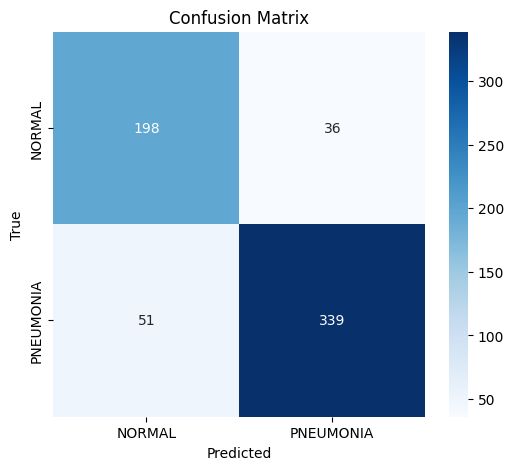

              precision    recall  f1-score   support

      NORMAL       0.80      0.85      0.82       234
   PNEUMONIA       0.90      0.87      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.85       624
weighted avg       0.86      0.86      0.86       624



In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs, _, _ = model(imgs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[inv_class_map[i] for i in range(num_classes)],
            yticklabels=[inv_class_map[i] for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ✅ Precision, Recall, F1 per class
report = classification_report(all_labels, all_preds,
                               target_names=[inv_class_map[i] for i in range(num_classes)])
print(report)
